<a href="https://colab.research.google.com/github/kenjan1974/titanic-analysis/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C_01_%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===== 數值欄位 vs Survived 的相關係數 =====
Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

===== Sex 分群生存率 =====
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

===== Embarked 分群生存率 =====
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

===== 隨機森林特徵重要度 =====
Fare        0.268374
Sex         0.261858
Age         0.260252
Pclass      0.084290
SibSp       0.051499
Parch       0.039111
Embarked    0.034615
dtype: float64


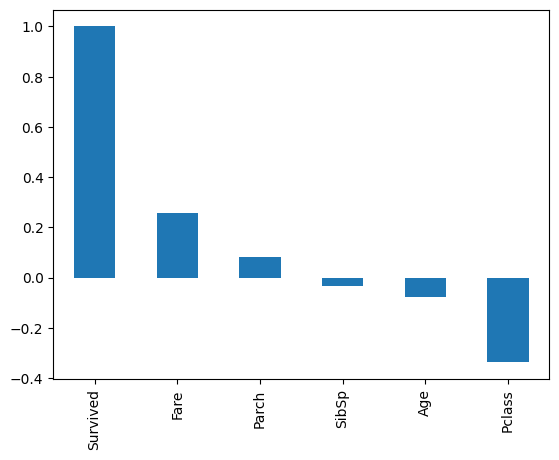

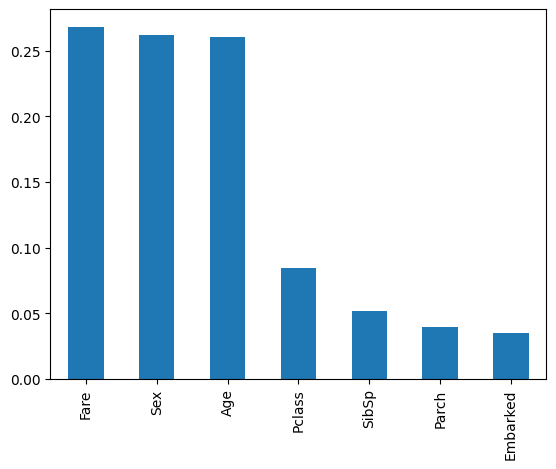

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. 載入資料
df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')

# 2. 欄位定義（請參考 Kaggle 官方說明）：
#    PassengerId：乘客編號
#    Survived   ：生存狀態（0＝未生存；1＝生存）
#    Pclass     ：艙等（1＝頭等艙；2＝商務艙；3＝經濟艙）
#    Name       ：姓名
#    Sex        ：性別
#    Age        ：年齡
#    SibSp      ：同船兄弟姊妹／配偶人數
#    Parch      ：同船父母／小孩人數
#    Ticket     ：票號
#    Fare       ：票價
#    Cabin      ：艙房號
#    Embarked   ：登船港口（C＝Cherbourg；Q＝Queenstown；S＝Southampton）

# 3. 數值欄位 vs 生存的相關係數
numeric = ['Pclass','Age','SibSp','Parch','Fare']
corr = df[numeric + ['Survived']].corr()['Survived'].sort_values(ascending=False)
print("===== 數值欄位 vs Survived 的相關係數 =====")
print(corr)

# 4. 類別欄位 vs 生存率
for col in ['Sex','Embarked']:
    rates = df.groupby(col)['Survived'].mean()
    print(f"\n===== {col} 分群生存率 =====")
    print(rates)

# 5. 隨機森林特徵重要度
#   - 先做簡單編碼 & 補值
df2 = df.copy()
for col in ['Sex','Embarked']:
    df2[col] = LabelEncoder().fit_transform(df2[col].astype(str))
df2[numeric] = df2[numeric].fillna(df2[numeric].median())
features = numeric + ['Sex','Embarked']

X = df2[features]
y = df2['Survived']
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("\n===== 隨機森林特徵重要度 =====")
print(importances)

# 6. 視覺化
corr.plot.bar(); plt.show()
importances.plot.bar(); plt.show()


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 複製並移除不必要欄位
df_train = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1).copy()

# 一次性填補所有缺值（利用 dict + fillna）
fill_values = {
    'Age':    df_train['Age'].median(),
    'Fare':   df_train['Fare'].median(),
    'Embarked': df_train['Embarked'].mode()[0],
    'Sex':      df_train['Sex'].mode()[0],
}
df_train = df_train.fillna(fill_values)

# 類別欄位 Label Encoding
le = LabelEncoder()
for col in ['Sex','Embarked']:
    df_train[col] = le.fit_transform(df_train[col])

# 切分特徵與目標
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_X = df_train.drop('Survived', axis=1)
train_y = df_train['Survived']

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log = LogisticRegression(random_state=0, max_iter=3000)
scores = cross_val_score(log, train_X, train_y, cv=5, scoring='accuracy')
print(scores)

[0.7877095  0.78651685 0.78089888 0.76966292 0.82022472]


In [16]:
# 資料前處理與比較示範
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 載入資料並移除純噪音與高缺失欄位
df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')
df = df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)  # PassengerId, Ticket 無直接意義；Cabin 缺失過多

# 將 Name 保留以後示範擷取 Title
df_original = df.copy()

# 分離特徵與目標
X = df.drop('Survived', axis=1)
y = df['Survived']

# 2. 缺失值處理策略比較（示範 Age 欄位）
X = df.drop(['Survived','Name'], axis=1)  # 連 Name 一起 drop
y = df['Survived']

strategies = ['mean', 'median', 'constant']
results_impute = {}
for strat in strategies:
    imputer = SimpleImputer(strategy=strat, fill_value=-1)
    X_imp = X.copy()

    # 1) 填補 Age
    X_imp['Age'] = imputer.fit_transform(X[['Age']])

    # 2) 再做 One-Hot，這時只剩 Sex、Embarked 等可以轉
    X_imp = pd.get_dummies(X_imp, columns=['Sex','Embarked'], dummy_na=False)

    # 3) 交叉驗證
    scores = cross_val_score(
        LogisticRegression(max_iter=1000),
        X_imp, y, cv=5, scoring='accuracy'
    )
    results_impute[strat] = scores.mean()

print("缺失值填補策略比較（Age）：", results_impute)


# 3. 類別欄位編碼比較
# A) LabelEncoder（假設原始有順序，但 Sex/Embarked 實際無序）
# 直接拆 X, y
X = df_train.drop('Survived', axis=1)  # 只移除目標欄位
y = df_train['Survived']

# A) LabelEncoder 版本
X_le = X.copy()
for col in ['Sex','Embarked']:
    # LabelEncoder：將類別映成整數，可能造成模型誤以為有順序
    X_le[col] = LabelEncoder().fit_transform(X_le[col].astype(str))

scores_le = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_le, y, cv=5, scoring='accuracy'
)
print(f"LabelEncoder 後 Accuracy: {scores_le.mean():.4f}")

# B) OneHotEncoder 版本
ct = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown='ignore'), ['Sex','Embarked'])],
    remainder='passthrough'  # 其餘欄位（Pclass, Age, SibSp, Parch, Fare）保留原樣
)
X_ohe = ct.fit_transform(X)  # 轉成 numpy array
scores_ohe = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_ohe, y, cv=5, scoring='accuracy'
)
print(f"OneHotEncoder 後 Accuracy: {scores_ohe.mean():.4f}")
# 比較重點：
# - LabelEncoder：簡單、產生 2 個欄位；但假設順序可能不合理
# - OneHotEncoder：無順序誤差，但欄位數增加


# 4. 特徵工程示例
df_fe = df_original.copy()

# 4.1 擷取 Title：從 Name 中抓出稱謂，反映社會地位與性別
df_fe['Title'] = df_fe['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

# 4.2 家庭規模 FamilySize：SibSp + Parch + 1，影響是否優先照顧家人
df_fe['FamilySize'] = df_fe['SibSp'] + df_fe['Parch'] + 1

# 4.3 是否獨自一人 IsAlone：FamilySize == 1 時即為獨自
df_fe['IsAlone'] = (df_fe['FamilySize'] == 1).astype(int)

# 4.4 年齡分箱 AgeBand：降低極端值干擾
df_fe['AgeBand'] = pd.qcut(df_fe['Age'].fillna(df_fe['Age'].median()), 4, labels=False)

# 4.5 票價分箱 FareBand：同樣分布式分箱
df_fe['FareBand'] = pd.qcut(df_fe['Fare'], 4, labels=False)

# 刪除原始雜訊欄位，編碼所有類別
df_fe = df_fe.drop(['Name'], axis=1)
df_fe = pd.get_dummies(
    df_fe,
    columns=['Sex','Embarked','Title','AgeBand','FareBand'],
    dummy_na=False
)

# 檢查型態，篩純數值
print("=== 各欄位型態 ===")
print(df_fe.dtypes)
X_num = df_fe.select_dtypes(include=[np.number]).drop('Survived', axis=1)
y = df_fe['Survived']

#填補缺失值 ---
df_fe['Age']  = df_fe['Age'].fillna(df_fe['Age'].median())
df_fe['Fare'] = df_fe['Fare'].fillna(df_fe['Fare'].median())

# 基線評估
X_fe = df_fe.drop('Survived', axis=1)
scores_fe = cross_val_score(LogisticRegression(max_iter=1000),
                            X_fe, df_fe['Survived'], cv=5).mean()
print(f"加入特徵工程後 Accuracy：{scores_fe:.4f}")
# 解說：
# - Title：社會階層＋性別資訊
# - FamilySize/IsAlone：家庭結構影響搶救助
# - AgeBand/FareBand：量化離散化，減少極端影響


train_X = df_train.drop('Survived', axis=1)
train_y = df_train['Survived']

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log = LogisticRegression(random_state=0, max_iter=3000)
scores = cross_val_score(log, train_X, train_y, cv=5, scoring='accuracy')
print(scores)

缺失值填補策略比較（Age）： {'mean': np.float64(0.7867679367271359), 'median': np.float64(0.7867742137969996), 'constant': np.float64(0.7844956374364446)}
LabelEncoder 後 Accuracy: 0.7890
OneHotEncoder 後 Accuracy: 0.7857
=== 各欄位型態 ===
Survived                int64
Pclass                  int64
Age                   float64
SibSp                   int64
Parch                   int64
Fare                  float64
FamilySize              int64
IsAlone                 int64
Sex_female               bool
Sex_male                 bool
Embarked_C               bool
Embarked_Q               bool
Embarked_S               bool
Title_Capt               bool
Title_Col                bool
Title_Don                bool
Title_Dr                 bool
Title_Jonkheer           bool
Title_Lady               bool
Title_Major              bool
Title_Master             bool
Title_Miss               bool
Title_Mlle               bool
Title_Mme                bool
Title_Mr                 bool
Title_Mrs                boo